In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from inference import SpikeFeatureExtractor
if False:
    path = "tmp/input_x_da.csv"
    spfe = SpikeFeatureExtractor()
    r = spfe.extract_from_csv(path, verbose=True,num_workers=18)
    d = pd.read_csv(path)
    print(d.columns)
    #column_names = ['ID', 'g_Na', 'g_Kd', 'g_CaT', 'g_CaS', 'g_KCa', 'g_A', 'g_H', 'g_leak']
    # g_Na, g_Kd, g_CaL, g_CaN, g_ERG, g_NMDA, g_leak,
    column_names = ['ID', 'g_Na', 'g_Kd', 'g_CaL', 'g_CaN', 'g_ERG', 'g_NMDA', 'g_leak']
    import stg
    import da

    V_th = -55.5
    # new clean df

    df_clean = pd.DataFrame(columns=['ID', 'y', 'spiking_times', 'g_s', 'g_u'])

    for i in range(len(r)):
        id = i
        y = d['y'][i]
        spiking_times = d["spiking_times"][i]
        g_s = d['g_s'][i]
        g_u = d['g_u'][i]

        label = r['label'][i]

        if label == 0:
            continue

        # create a new row
        new_row = pd.Series([id, y, spiking_times, g_s, g_u], index=df_clean.columns)
        # append the new row to the dataframe
        df_clean = pd.concat([df_clean, new_row.to_frame().T], ignore_index=True)

    # save the dataframe to a csv file
    df_clean.to_csv("tmp/input_x_da_clean.csv", index=False)

    d = df_clean

    df = pd.DataFrame(columns=column_names)
    for i in range(len(d)):
        id = d['ID'][i]
        g_s = d['g_s'][i]
        g_u = d['g_u'][i]
        g_bar = da.generate_neuromodulated_population(16, V_th, g_s, g_u)
        g_Na = g_bar[:, 0] # 16 elements
        g_Kd = g_bar[:, 1]
        g_CaT = g_bar[:, 2]
        g_CaS = g_bar[:, 3]
        g_KCa = g_bar[:, 4]
        g_A = g_bar[:, 5]
        g_H = g_bar[:, 6]
#        g_leak = g_bar[:, 7]
        for j in range(len(g_Na)):
            # create a new row
            #new_row = pd.Series([id, g_Na[j], g_Kd[j], g_CaT[j], g_CaS[j], g_KCa[j], g_A[j], g_H[j], g_leak[j]], index=column_names)
            new_row = pd.Series([id, g_Na[j], g_Kd[j], g_CaT[j], g_CaS[j], g_KCa[j], g_A[j], g_H[j]], index=column_names)
            # append the new row to the dataframe
            df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

    df.to_csv("tmp/gt_x_da.csv", index=False)

    

In [2]:

import pandas as pd
import numpy as np
from tqdm import tqdm

# Define file paths
paths = {
    "x_input": "tmp/input_x_da_clean.csv",
    "gt_input": "tmp/gt_x_sim_da.csv",
    "pred_input": "tmp/predictions_x_sim_da.csv",
    "output": "tmp/output_x_da.csv",
    "output_random": "tmp/output_random_x_da.csv"
}

if True:
    def van_rossum_distance(u, v, dt = 0.1, epsilon = 1e-6):
        """Efficient calculation of the van Rossum distance between two spike trains u and v."""


        u = np.asarray(u)
        v = np.asarray(v)
        u = u-u[0]
        if len(v) > 0:
            v = v-v[0]

        isi_u = np.diff(u)
        tau = max(isi_u) + min(isi_u)
        tau = tau / 2

        # since tau is constant, we compute the kernel only once
        def kernel(t):
            return np.exp(-t / tau) / tau
        
        max_T = - tau * np.log(epsilon*tau) # time such that kernel(t) < epsilon
        t_kernel = np.arange(0, max_T + dt, dt)
        kernel_values = kernel(t_kernel)

        # u and v aligned with dt
        u_idx = np.round(u/dt).astype(int)
        v_idx = np.round(v/dt).astype(int)

        u_max = u_idx.max()
        if len(v_idx) > 0:
            v_max = v_idx.max()
        else:
            v_max = -1
        w = np.zeros(int(np.ceil(max(v_max, u_max) / dt) + 1))

        # at each spike time, we add the kernel to the window
        for i in u_idx:
            w[i:i+len(kernel_values)] += kernel_values
        for i in v_idx:
            w[i:i+len(kernel_values)] -= kernel_values
        
        w = w**2
        d = sum(w) * dt
        return d

    def process_population(local_df):
        # from a list into a pandas df
        local_df = pd.DataFrame(local_df)

        # get the x, gt and pred
        x = local_df[local_df['label'] == 'x']['spiking_times'].values[0]
        gt = local_df[local_df['label'] == 'gt']['spiking_times'].values
        pred = local_df[local_df['label'] == 'p']['spiking_times'].values

        num_d = 0
        num_n = 0

        for i in range(len(gt)):
            try:
                num_d += van_rossum_distance(x, gt[i])
            except:
                num_d += np.nan

        for i in range(len(pred)):
            try:
                num_n += van_rossum_distance(x, pred[i])
            except:
                num_n += np.nan

        # get the mean
        if len(gt) > 0:
            num_d = num_d / len(gt)
        else:
            num_d = np.nan
        if len(pred) > 0:
            num_n = num_n / len(pred)
        else:
            num_n = np.nan

        return local_df['ID'].values[0], num_d, num_n
    
    # Load data
    df_x = pd.read_csv(paths["x_input"])
    df_gt = pd.read_csv(paths["gt_input"])
    df_pred = pd.read_csv(paths["pred_input"])

    # Initialize feature extractor
    spfe = SpikeFeatureExtractor(truncate_burst=True)

    # Extract spiking times
    for df in [df_x, df_gt, df_pred]:
        df['spiking_times'] = spfe.extract_from_dataframe(df, verbose=True, num_workers=18)['spiking_times']

    # Worker function for multiprocessing
    def process_index(idx):
        local_records = []
        current_id = df_x.at[idx, 'ID']
        x_spike = df_x.at[idx, 'spiking_times']
        
        local_records.append({'ID': current_id, 'spiking_times': x_spike, 'label': 'x'})

        matching_gt = df_gt[df_gt['ID'] == current_id]
        local_records.extend([
            {'ID': current_id, 'spiking_times': row['spiking_times'], 'label': 'gt'}
            for _, row in matching_gt.iterrows()
        ])

        matching_pred = df_pred[df_pred['ID'] == current_id]
        local_records.extend([
            {'ID': current_id, 'spiking_times': row['spiking_times'], 'label': 'p'}
            for _, row in matching_pred.iterrows()
        ])

        return process_population(local_records)

    num_cpu = 19
    with Pool(processes=num_cpu) as pool:
            results = list(tqdm(pool.imap(process_index, range(len(df_x))), total=len(df_x)))

    # Create DataFrame from results
    df_results = pd.DataFrame(results, columns=['ID', 'd', 'n'])
    df_results['d'] = df_results['d'].astype(float)
    df_results['n'] = df_results['n'].astype(float)

    # from the ID, we get the g_s and g_u
    df_results['g_s'] = df_results['ID'].apply(lambda x: df_x[df_x['ID'] == x]['g_s'].values[0])
    df_results['g_u'] = df_results['ID'].apply(lambda x: df_x[df_x['ID'] == x]['g_u'].values[0])
    df_results['g_s'] = df_results['g_s'].astype(float)
    df_results['g_u'] = df_results['g_u'].astype(float)
    # Save results to CSV
    df_results.to_csv(paths["output"], index=False)
    # Print the results
    print("Results saved to:", paths["output"])
    # Print the results
    print("Results:")
    print(df_results)

    def process_index_random(idx):
        local_records = []
        current_id = df_x.at[idx, 'ID']
        x_spike = df_x.at[idx, 'spiking_times']
        
        local_records.append({'ID': current_id, 'spiking_times': x_spike, 'label': 'x'})

        matching_gt = df_gt[df_gt['ID'] == current_id]
        local_records.extend([
            {'ID': current_id, 'spiking_times': row['spiking_times'], 'label': 'gt'}
            for _, row in matching_gt.iterrows()
        ])

        matching_pred = df_pred[df_pred['ID'] == ((current_id + 2) % len(df_x))]
        local_records.extend([
            {'ID': current_id, 'spiking_times': row['spiking_times'], 'label': 'p'}
            for _, row in matching_pred.iterrows()
        ])

        return process_population(local_records)

    num_cpu = 19
    with Pool(processes=num_cpu) as pool:
            results = list(tqdm(pool.imap(process_index_random, range(len(df_x))), total=len(df_x)))
    # Create DataFrame from results
    df_results_random = pd.DataFrame(results, columns=['ID', 'd', 'n'])
    df_results_random['d'] = df_results_random['d'].astype(float)
    df_results_random['n'] = df_results_random['n'].astype(float)
    # from the ID, we get the g_s and g_u
    df_results_random['g_s'] = df_results_random['ID'].apply(lambda x: df_x[df_x['ID'] == x]['g_s'].values[0])
    df_results_random['g_u'] = df_results_random['ID'].apply(lambda x: df_x[df_x['ID'] == x]['g_u'].values[0])
    df_results_random['g_s'] = df_results_random['g_s'].astype(float)
    df_results_random['g_u'] = df_results_random['g_u'].astype(float)
    # Save results to CSV
    df_results_random.to_csv(paths["output_random"], index=False)
    # Print the results
    print("Random Results saved to:", paths["output_random"])
    # Print the results
    print("Random Results:")
    print(df_results_random)

Preprocessing data
Data preprocessed, extracting features
Extracting features from 1695 samples using 18 workers


100%|██████████| 18/18 [00:00<00:00, 324.54it/s]

Preprocessing data


Data preprocessed, extracting features
Extracting features from 26946 samples using 18 workers


100%|██████████| 18/18 [00:00<00:00, 50.85it/s]

Preprocessing data


Data preprocessed, extracting features
Extracting features from 27120 samples using 18 workers


100%|██████████| 1695/1695 [03:00<00:00,  9.39it/s]


Results saved to: tmp/output_x_da.csv
Results:
        ID          d          n       g_s        g_u
0        4   0.001472   0.000524 -3.981537  12.978016
1        9   0.000559   0.000929  1.032067   7.965333
2       10   0.000831   0.000796  1.981880   8.804832
3       12   0.002184   0.000511  0.478970  15.018435
4       13   0.005728   0.003654  0.999017   3.359691
...    ...        ...        ...       ...        ...
1690  3871   0.023761   0.031738 -2.745798   5.490862
1691  3872   9.203885   0.895088 -7.360953  16.892292
1692  3875   0.000954   0.000431  6.560994   8.132258
1693  3880   0.115976   0.111330  4.622108   2.095082
1694  3890  27.800035  18.983792 -5.898442   3.847242

[1695 rows x 5 columns]


100%|██████████| 1695/1695 [02:12<00:00, 12.74it/s]


Random Results saved to: tmp/output_random_x_da.csv
Random Results:
        ID          d         n       g_s        g_u
0        4   0.001472       NaN -3.981537  12.978016
1        9   0.000559       NaN  1.032067   7.965333
2       10   0.000831  0.001098  1.981880   8.804832
3       12   0.002184       NaN  0.478970  15.018435
4       13   0.005728       NaN  0.999017   3.359691
...    ...        ...       ...       ...        ...
1690  3871   0.023761       NaN -2.745798   5.490862
1691  3872   9.203885  0.129769 -7.360953  16.892292
1692  3875   0.000954  0.000804  6.560994   8.132258
1693  3880   0.115976       NaN  4.622108   2.095082
1694  3890  27.800035       NaN -5.898442   3.847242

[1695 rows x 5 columns]


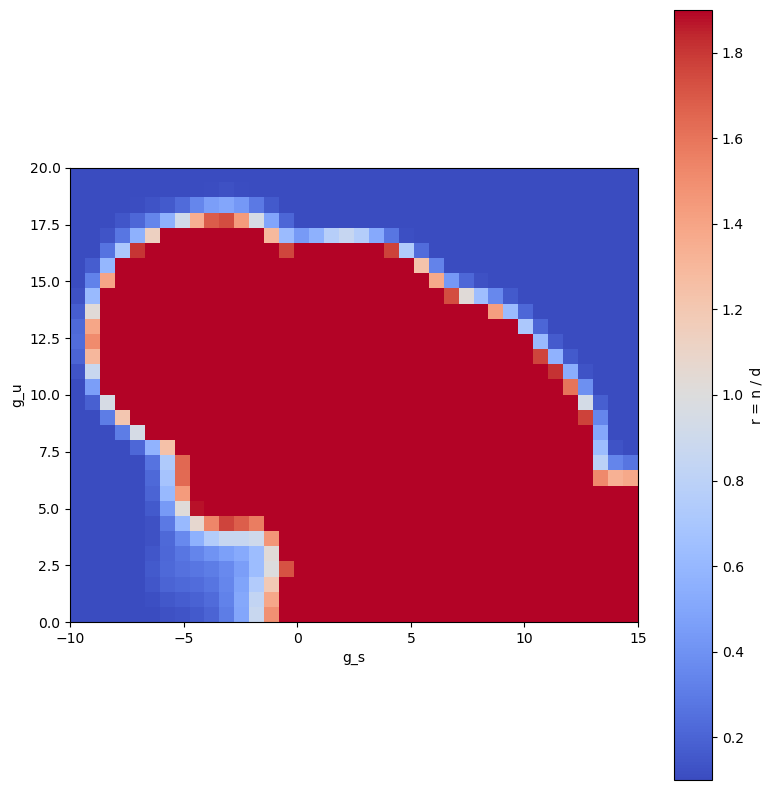

In [ ]:
# load the two output files
df_results = pd.read_csv(paths["output"])
df_results_random = pd.read_csv(paths["output_random"])

# compute r = n/d
df_results['r'] = df_results['n'] / df_results['d']
df_results_random['r'] = df_results_random['n'] / df_results_random['d']

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from scipy.ndimage import gaussian_filter

# We make 2 differents figures, one for the random and one for the normal. We plot the binned R (with interpolation in the missing values) in the 
# g_s - g_u space. x_lim from -20 to 20 and y_lim from 0 to 20.
def plot_binned_heatmap(df, title, xlim=(-20, 20), ylim=(0, 20), bins=30, sigma=2, save_path=None):
    # Bin the data
    x = df['g_s']
    y = df['g_u']
    z = df['r']

    

    # Ensure same number of bins in x and y, and calculate bin size
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]
    bin_size = min(x_range, y_range) / bins
    x_bins = int(np.ceil(x_range / bin_size))
    y_bins = int(np.ceil(y_range / bin_size))

    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins], range=[xlim, ylim], weights=z)
    counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], range=[xlim, ylim])

    with np.errstate(invalid='ignore', divide='ignore'):
        average = heatmap / counts
        average[counts == 0] = np.nan

    # Interpolate missing values using Gaussian filter
    interpolated = gaussian_filter(np.nan_to_num(average, nan=0.0), sigma=sigma)

    # Plotting
    plt.figure(figsize=(8, 8))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    cmap = plt.get_cmap('coolwarm')
    vn = 0.9
    norm = mcolors.Normalize(vmin=1 - vn, vmax=1 + vn)

    plt.imshow(interpolated.T, extent=extent, origin='lower', aspect='equal', cmap=cmap, norm=norm)
    plt.colorbar(label='r = n / d')  # Uncomment if you want the colorbar
    plt.xlabel('g_s')
    plt.ylabel('g_u')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Plot normal results
plot_binned_heatmap(df_results, "r = n/d (Normal Predictions)", xlim=(-10, 15), ylim=(0, 20), save_path="figures/heatmap_normal_da.svg")

# Plot random results
plot_binned_heatmap(df_results_random, "r = n/d (Random Predictions)", xlim=(-10, 15), ylim=(0, 20), save_path="figures/heatmap_random_da.svg")


